In [1]:
from simple_model.SimpleModel import cols, SimpleModel
import simple_model.GenerateSimpleModelData as gsm
import torch
import pyro.distributions as dist
import pandas as pd
import pyro
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_policy_heatmap(filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    with torch.no_grad():
        df = pd.DataFrame()
        for i in range(50,90):
            for j in range(70,150):
                probs = [model.policy(torch.tensor([i, j]).float())[0].numpy().item(0), 
                        model.policy(torch.tensor([i, j]).float())[1].numpy().item(0)]
                prob_no_action = np.exp(probs[0])/(np.exp(probs[0]) + np.exp(probs[1]))
                df = df.append({'s_1': i, 's_2': j, 'prob-no-action': prob_no_action}, ignore_index=True)
        logit_probs = df.pivot("s_1", "s_2", "prob-no-action")
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
        sns.heatmap(logit_probs, vmax=0.50, ax=ax1)
        sns.heatmap(logit_probs, ax=ax2)
        plt.show()
    return df

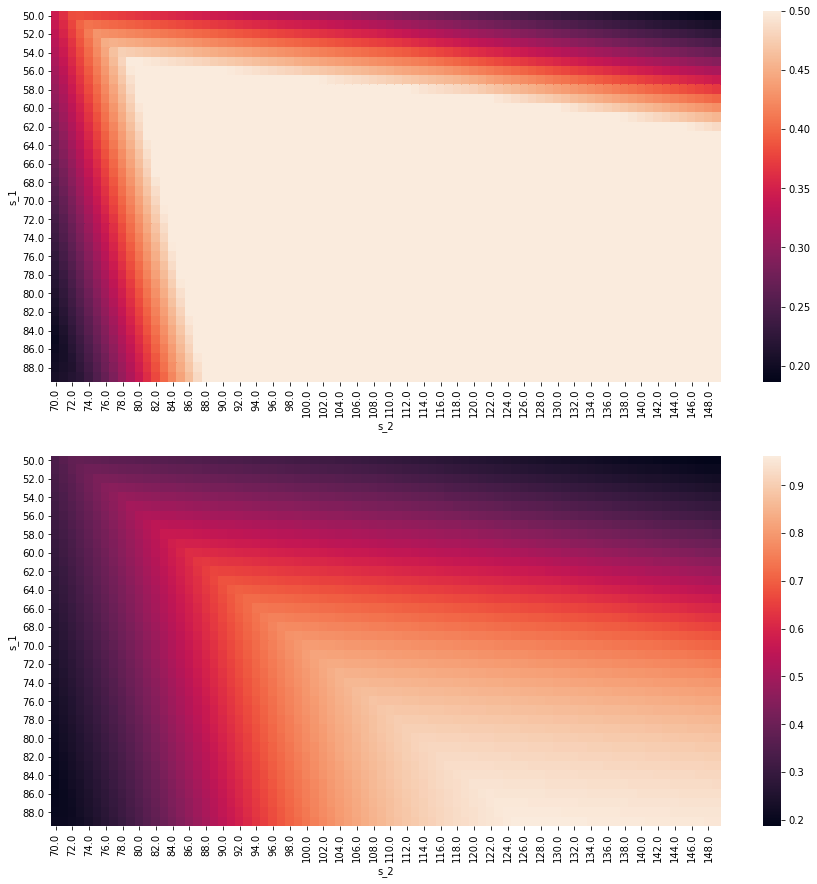

In [86]:
df = generate_policy_heatmap("/Users/faaiz/simple-model/model-state-20-20")

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


def myplot(x, y, s, action, bins=1000):
    if action == 0:
        plot_range = [[-20, 20], [-20, 20]]
    else:
        plot_range = [[0, 40], [0, 40]]    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=plot_range)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [10]:
df_guide = pd.DataFrame()
for i in range(10000):
    state = gsm.S_t()
    s0_1, s0_2 = state.s_t[0], state.s_t[1]
    xt, ut = state.get_xt(), state.get_ut()
    action = gsm.physicians_policy(xt, ut)
    df_guide = df_guide.append({'s0_1': s0_1, 's0_2': s0_2, 'x0': xt, 'a0': action}, ignore_index=True)

In [63]:
def generate_simulator_heatmap(df, filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    df = df[['s0_1', 's0_2', 'x0', 'a0']]
    df_0 = pd.DataFrame()
    df_1 = pd.DataFrame()
    with torch.no_grad():
        for index, row in df.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, xt = row['a0'], row['x0']
            st_loc, st_tril, st_diag = model.st_network(torch.tensor((s0_1, s0_2, action, xt)).float())
            z = torch.zeros(1)
            scale_tril = torch.tensor([
                st_diag[0], z,
                st_tril[0], st_diag[1]
            ]).view(2,2)
            s1 = dist.MultivariateNormal(loc=st_loc, scale_tril=scale_tril).sample().numpy()
            if action == 0:
                df_0 = df_0.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1)}, ignore_index=True)
            else:
                df_1 = df_1.append({'s0_1': s0_1, 's0_2': s0_2, 's1_1': s1.item(0), 's1_2': s1.item(1)}, ignore_index=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    img, extent = myplot(df_0['s1_1']-df_0['s0_1'], df_0['s1_2']-df_0['s0_2'], 16, 0)
    ax1.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax1.set_title("$S_1 - S_0$ for $A_0 = 0$")
    img, extent = myplot(df_1['s1_1']-df_1['s0_1'], df_1['s1_2']-df_1['s0_2'], 16, 1)
    ax2.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    ax2.set_title("$S_1 - S_0$ for $A_0 = 1$")
    plt.show()

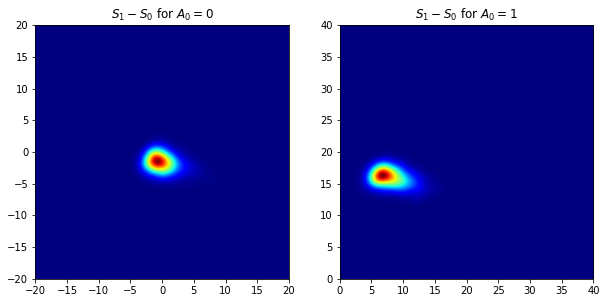

In [88]:
generate_simulator_heatmap(df_guide, "/Users/faaiz/simple-model/model-state-20-20")

In [43]:
def get_policy_accuracy(df, filename):
    model = SimpleModel()
    model.load_state_dict(torch.load(filename))
    model.eval()
    acc = 0
    with torch.no_grad():
        for index, row in df.iterrows():
            s0_1, s0_2 = row['s0_1'], row['s0_2']
            action, xt = row['a0'], row['x0']
            pred_action = dist.Categorical(logits=model.policy(torch.tensor((s0_1, s0_2)).float())).sample().numpy().item(0)
            acc += (pred_action == action)
    return acc/len(df)*100

In [87]:
get_policy_accuracy(df_guide, "/Users/faaiz/simple-model/model-state-20-20")

62.67